In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,AsinhNorm
%matplotlib inline
import galsim
from scipy.optimize import minimize,least_squares

## GalSim is an extremely powerful library for handling modeling of extragalactic survey fields.

As a simple demonstration, here's a block of code that will produce a noisy, psf-convolved galaxy image similar to that at the end of the previous notebook.

This one, however, will be _much_ more accurate, as it automatically optimizes the convolution parameters to produce an accurate result.

The examples here will draw heavily on GalSim, a largely Pythonic toolkit for simulating extraGalactic survey fields, designed with an emphasis on weak lensing.

This makes many of the operations from the previous notebook far easier.

https://galsim-developers.github.io/GalSim


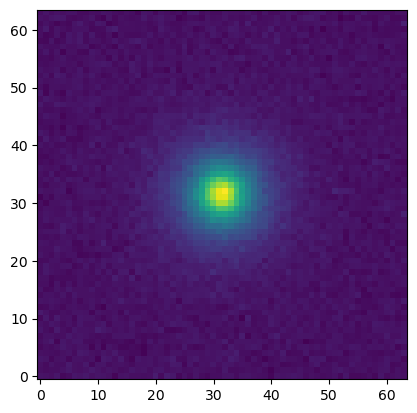

In [2]:
sersicObject = galsim.Sersic(n=1,scale_radius=4.,flux=1.)
psfObject = galsim.Gaussian(sigma=1.)
psfConvObject = galsim.Convolve([psfObject,sersicObject])

image = psfConvObject.drawImage(scale=1.)

noise = galsim.GaussianNoise(sigma=0.0001)
noise.applyTo(image)

plt.imshow(image.array,origin='lower')
plt.show()

## These are some simple functions to help with measuring the brightness of faint sources.



In [19]:
def aperturePhotom(image,center=None,radius=None):
    '''
    Sum up the flux inside a circular aperture.
    '''
    
    if radius is None:
        return np.sum(image)
    nx,ny = image.shape
    if center is None:
        center = [(nx-1)/2., (ny-1)/2.]
    xcoords,ycoords = np.arange(nx)-center[0],np.arange(ny)-center[1]
    xx,yy = np.meshgrid(xcoords,ycoords)
    r = np.sqrt(xx**2+yy**2)
    aperture = r<radius
    flux = np.sum(image[aperture])
    return flux

def make_star_image(flux=1, sigma = 1.0,nx=64,ny=64,offset=[0,0],add_noise = False,noise_std = 0.001):
    psfObj = galsim.Gaussian(sigma=1.0, flux = flux)
    simImage = psfObj.drawImage(scale=1.0,offset=offset,nx=nx,ny=ny)
    if add_noise:
        noise = galsim.GaussianNoise(sigma=noise_std)
        noise.applyTo(simImage)
    return simImage.array

def make_star_images(fluxes=[1,1],sigmas=[4.,3.],nx=64,ny=64,offsets=[[0,0],[5,-3]],add_noise=False, noise_std = 0.001):
    simImage = np.zeros((nx,ny))
    for i in range(len(fluxes)):
        simImage = simImage + make_star_image(flux=fluxes[i],sigma=sigmas[i],nx=nx,ny=ny,offset=offsets[i],noise_std=noise_std,add_noise=add_noise)
    return simImage


def modelResiduals(parameters,image,psf = None):
    # Get the model prediction.
    model = '' # Add your model here.
    
    return  (model - image).flatten()



def modelPhotom(image, parameters, residualsFunction,psf=None):
    '''
    Fit a parameterized model to the provided image.
    '''
    result = least_squares(residualsFunction, parameters, method='lm', args=(image,psf))#,options={'xtol':1e-12})
    return result.x

## Next up: Let's try to do some measurements! 

I've written a simple function that does aperture photometry. Here's a demonstration.

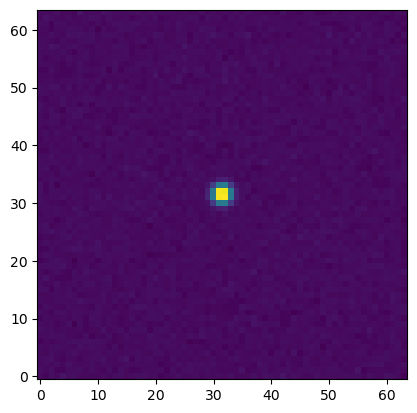

Measured flux: 0.9112


In [38]:
# Try out the photometry on a model star.

image = make_star_image(sigma=2.,add_noise=True)

# Show the image.
plt.imshow(image,origin='lower')
plt.show()

# First, estimate the aperture photometry
apertureEst = aperturePhotom(image,radius=2.5)
print(f"Measured flux: {apertureEst:.04}")



## Problem 1: Write a simple maximum-likelihood estimator for the flux of a simulated star. Assume, for now, that you know the PSF.

In [36]:
psfObject.gsparams

galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)

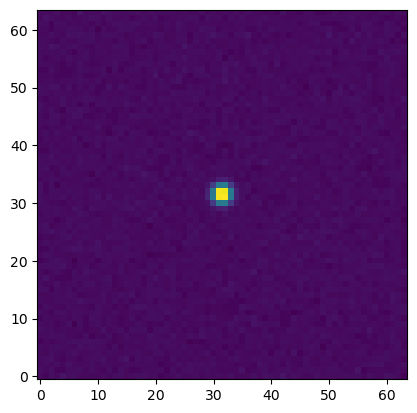

1.0028477

In [41]:
plt.imshow(image,origin='lower')
plt.show()


psfObj = galsim.Gaussian(sigma=1.0, flux = 1)
simImage = psfObj.drawImage(scale=1.0, nx=64,ny=64)

np.sum(image * simImage.array)/ np.sum(simImage.array * simImage.array)

## Problem 2: let's compare the performance of these estimators. Write a function to make new noise realizations of the galaxies, and measure the distribution of the results.



In [43]:
def aperture_me(image):
    psfObj = galsim.Gaussian(sigma=1.0, flux = 1)
    simImage = psfObj.drawImage(scale=1.0, nx=64,ny=64)
    return np.sum(image * simImage.array)/ np.sum(simImage.array * simImage.array)

In [44]:
n_realizations = 1000
apertureEst_array = np.zeros(n_realizations)
apertureEst_array_me = np.zeros(n_realizations)


for i in range(n_realizations):
    this_image = make_star_image(add_noise=True)
    apertureEst_array[i] = aperturePhotom(this_image,radius=2)
    apertureEst_array_me[i] = aperture_me(this_image)



Bias and variance:
Aperture photometry -- bias: -0.16, scatter: 0.0001131


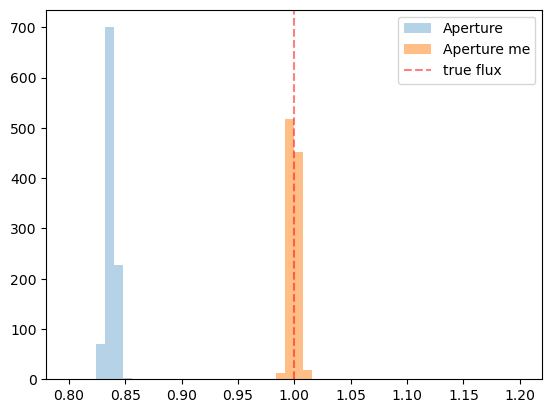

In [45]:
print("Bias and variance:")
print(f"Aperture photometry -- bias: {np.mean(apertureEst_array)-1:.02}, scatter: {np.std(apertureEst_array)/np.sqrt(n_realizations):.04}")


bins = np.linspace(0.8,1.2,51)
plt.hist(apertureEst_array,bins=bins,alpha=0.33,label='Aperture')
plt.hist(apertureEst_array_me,bins=bins,alpha=0.5,label='Aperture me')

plt.axvline(1,color='red',alpha=0.5,linestyle='--',label='true flux')
plt.legend()
plt.show()


## Problem 3: Model fitting.

Use your favorite fitter, and your own likelihood, to extract the flux by fitting a parameterized model to the star image. Allow the only the flux to vary. Compare the performance of this method with the other two.

In [ ]:
modelPhotom(image, parameters, residualsFunction,psf=None)

## Problem 4: Science traceability.

Suppose that we have determined that sufficiently accurate photometric redshifts will require that our photometry be unbiased to less than 1\%.

How well do we need to know the size of our PSF?

For this problem, you'll want to compare the performance of the estimators you've developed so far, but to do so as a function of a *model mis-specification* error in the PSF itself. You've already done some of this -- the morning work emphasized the effect of the size of an aperture on aperture photometry -- but here you'll look at the effect on more sophisticated estimators.

What does the max-likelihood estimator do if we use the wrong template?
What happens to the forward model?

At the end of this task, you should be able to make a plot of the statistical accuracy of the photometry -- its bias, and perhaps the scatter -- as a function of your chosen measure of the accuracy of the PSF model.

### Bonus: Replace the PSF in the simulation (but not the measurement) with a galsim.Airy object, ensuring that it has the same FWHM as the original Gaussian. 

Repeat the above experiments, and demonstrate how much using an *approximate* PSF matters for the accuracy of the measurement.

## Challenge Problem: Blending

Real galaxies don't space themselves conveniently on the sky, and the light often overlaps.

The following box shows you the simplest example -- two nearby point sources on the sky.

Can you measure their fluxes accurately, using the tools you've already developed? How close can you get them while still retrieving an accurate measurement for both fluxes?

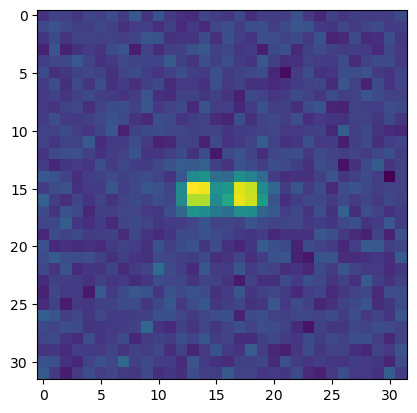

In [7]:
image = make_star_images(fluxes=[1,1.5],sigmas=[4.,3.],nx=32,ny=32,offsets=[[-2,0],[2,0]],add_noise=True,noise_std=0.005)
plt.imshow(image)
plt.show()